In [3]:
import pandas as pd
from pyproj import Transformer, CRS
import numpy as np
from typing import Optional, Union
import requests
import matplotlib.pyplot as plt
from PIL import Image
import yaml
import io
import time
from tqdm.notebook import tqdm
from typing import Optional, Tuple, Dict, Any
import re

# Irish Planning Data Driven Project

## Link to Applicaion planning points from gov.ie
https://data.gov.ie/dataset/planning-application-points1

## Kaggle link to property prices
https://www.kaggle.com/datasets/erinkhoo/property-price-register-ireland



In [1]:
# --- Configuration ---
# Specify the path to your input data file (e.g., CSV)
# Make sure the file path is correct for your system.
# Use raw strings (r'...') or double backslashes ('\\') on Windows if needed.
input_file_path = 'your_planning_data.csv'

# Specify the path for the output file with added GPS coordinates
output_file_path = 'planning_data_with_gps.csv'

# Define the column names for the source coordinates
x_col = 'x'
y_col = 'y'

# Define the names for the new GPS coordinate columns
lat_col = 'latitude'
lon_col = 'longitude'

# Define the EPSG codes
# Source CRS: ITM (Irish Transverse Mercator)
source_crs_epsg = 2157
# Target CRS: WGS84 (standard GPS coordinates)
target_crs_epsg = 4326

In [3]:
def transform_coords_df(
    data: Union[pd.DataFrame, str],
    x_col: str = 'x',
    y_col: str = 'y',
    lat_col: str = 'latitude',
    lon_col: str = 'longitude',
    source_crs_epsg: int = 2157, # Default: ITM (Ireland)
    target_crs_epsg: int = 4326, # Default: WGS84 (GPS)
    input_file_type: str = 'csv', # 'csv' or 'excel' if data is a path
    output_path: Optional[str] = None, # Optional: Path to save the result
    **kwargs # Allow passing extra arguments to pd.read_csv/read_excel
    ) -> Optional[pd.DataFrame]:
    """
    Transforms coordinates from a source CRS to a target CRS within a pandas DataFrame.

    Handles loading data from a file path or using an existing DataFrame.

    Args:
        data (Union[pd.DataFrame, str]): Either a pandas DataFrame object
                                         or a string path to the input data file (CSV or Excel).
        x_col (str): Name of the column containing the source x/easting coordinates.
                     Defaults to 'x'.
        y_col (str): Name of the column containing the source y/northing coordinates.
                     Defaults to 'y'.
        lat_col (str): Name for the new column containing the target latitude.
                       Defaults to 'latitude'.
        lon_col (str): Name for the new column containing the target longitude.
                       Defaults to 'longitude'.
        source_crs_epsg (int): EPSG code of the source coordinate reference system.
                               Defaults to 2157 (ITM).
        target_crs_epsg (int): EPSG code of the target coordinate reference system.
                               Defaults to 4326 (WGS84).
        input_file_type (str): Specifies the file type if 'data' is a path.
                               Options: 'csv', 'excel'. Defaults to 'csv'.
        output_path (Optional[str]): If provided, the path to save the resulting
                                     DataFrame as a CSV file. Defaults to None (no saving).
        **kwargs: Additional keyword arguments to pass to pandas read function
                  (e.g., `sep='\t'` for pd.read_csv).

    Returns:
        Optional[pd.DataFrame]: The DataFrame with added latitude and longitude columns,
                                or None if a critical error occurred (e.g., file not found,
                                essential columns missing).
    """
    try:
        # --- Load Data ---
        if isinstance(data, str):
            input_path = data
            print(f"Loading data from: {input_path}")
            if input_file_type.lower() == 'csv':
                df = pd.read_csv(input_path, **kwargs)
            elif input_file_type.lower() == 'excel':
                df = pd.read_excel(input_path, **kwargs)
            else:
                raise ValueError(f"Unsupported input_file_type: '{input_file_type}'. Use 'csv' or 'excel'.")
            print(f"Successfully loaded {len(df)} records.")
        elif isinstance(data, pd.DataFrame):
            df = data.copy() # Work on a copy to avoid modifying the original DataFrame outside the function
            print(f"Using provided DataFrame with {len(df)} records.")
        else:
            raise TypeError("Input 'data' must be a pandas DataFrame or a file path string.")

        print("Columns found:", df.columns.tolist())

        # --- Data Cleaning and Preparation ---
        if x_col not in df.columns or y_col not in df.columns:
            print(f"Error: Required source coordinate columns '{x_col}' and/or '{y_col}' not found.")
            return None # Indicate critical error

        df[x_col] = pd.to_numeric(df[x_col], errors='coerce')
        df[y_col] = pd.to_numeric(df[y_col], errors='coerce')

        valid_coords_mask = df[x_col].notna() & df[y_col].notna()
        num_valid = valid_coords_mask.sum()
        num_invalid = len(df) - num_valid

        if num_valid == 0:
            print(f"\nWarning: No valid numeric coordinates found in columns '{x_col}' and '{y_col}'.")
            print("Adding empty coordinate columns, but no transformation performed.")
            df[lon_col] = np.nan
            df[lat_col] = np.nan
            # Still return the df with empty columns added
        else:
            print(f"\nFound {num_valid} records with valid coordinates to transform.")
            if num_invalid > 0:
                print(f"Found {num_invalid} records with missing/invalid source coordinates.")

            # --- Coordinate Transformation ---
            print(f"\nSetting up transformation from EPSG:{source_crs_epsg} to EPSG:{target_crs_epsg}...")
            crs_source = CRS.from_epsg(source_crs_epsg)
            crs_target = CRS.from_epsg(target_crs_epsg)
            transformer = Transformer.from_crs(crs_source, crs_target, always_xy=True)

            print("Performing coordinate transformation...")
            df[lon_col] = np.nan
            df[lat_col] = np.nan

            x_coords = df.loc[valid_coords_mask, x_col].values
            y_coords = df.loc[valid_coords_mask, y_col].values

            # Perform transformation (transformer expects x, y -> returns lon, lat due to always_xy=True)
            lon_transformed, lat_transformed = transformer.transform(x_coords, y_coords)

            df.loc[valid_coords_mask, lon_col] = lon_transformed
            df.loc[valid_coords_mask, lat_col] = lat_transformed
            print("Transformation complete.")

        # --- Save Output (Optional) ---
        if output_path:
            try:
                print(f"\nSaving updated data to: {output_path}")
                df.to_csv(output_path, index=False, encoding='utf-8-sig')
                print("Save successful.")
            except Exception as e:
                print(f"Error saving file to {output_path}: {e}")
                # Continue to return the DataFrame even if saving failed

        return df

    except FileNotFoundError:
        print(f"Error: Input file not found at '{data}'. Please check the path.")
        return None
    except (ValueError, TypeError) as ve:
        print(f"Data processing error: {ve}")
        return None
    except ImportError:
        print("Error: Required libraries not found.")
        print("Please ensure pandas and pyproj are installed: pip install pandas pyproj")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        import traceback
        traceback.print_exc() # Print detailed traceback for unexpected errors
        return None


In [15]:
def clean_planning_data(
    input_path: str,
    output_path: str = 'application_file_cleaned.csv',
    easting_col: str = 'ITMEasting',
    northing_col: str = 'ITMNorthing'
    ) -> Optional[pd.DataFrame]:
    """
    Correctly cleans a planning application CSV file by:
    1. Removing rows ONLY if the 'easting_col' contains actual letters (a-zA-Z).
       Rows with NaN, None, empty strings (''), whitespace-only strings (' '),
       or numbers/punctuation in 'easting_col' will NOT be removed by this check.
    2. Removing the 'easting_col' and 'northing_col' columns.
    3. Saving the cleaned data to 'output_path'.

    Args:
        input_path (str): Path to the input CSV file.
        output_path (str): Path to save the cleaned CSV file.
                           Defaults to 'application_file_cleaned.csv'.
        easting_col (str): Name of the ITM Easting column to check for letters
                           and subsequently remove. Defaults to 'ITMEasting'.
        northing_col (str): Name of the ITM Northing column to remove.
                            Defaults to 'ITMNorthing'.

    Returns:
        Optional[pd.DataFrame]: The cleaned DataFrame, or None if an error occurred.
    """
    print(f"--- Starting Corrected Cleaning Process ---")
    print(f"Input file: {input_path}")
    print(f"Output file: {output_path}")
    print(f"Checking column: '{easting_col}' for actual letters (A-Z, a-z).")
    print(f"Columns to remove: ['{easting_col}', '{northing_col}']")

    try:
        # 1. Read the CSV file
        # Use low_memory=False to help with potentially mixed data types in columns
        try:
            df = pd.read_csv(input_path, low_memory=False)
        except Exception as read_err:
            print(f"Warning: Initial read attempt failed ({read_err}). Trying basic read.")
            df = pd.read_csv(input_path) # Fallback

        initial_rows = len(df)
        if initial_rows == 0:
             print(f"Input file '{input_path}' is empty. No cleaning needed.")
             # Optionally save an empty file or just return None/empty DataFrame
             df.to_csv(output_path, index=False, encoding='utf-8-sig')
             return df

        print(f"\nRead {initial_rows} rows from {input_path}.")

        # 2. Identify rows where 'easting_col' contains letters, handling NaNs correctly
        if easting_col not in df.columns:
            print(f"Error: Column '{easting_col}' not found in the input file. Cannot perform cleaning check.")
            return None

        # Create the mask safely:
        # - Use .str accessor which handles NaN implicitly (returns NaN for contains check)
        # - Apply .contains(r'[a-zA-Z]') -> returns True, False, or NaN
        # - Fill resulting NaN values with False (meaning NaNs don't contain letters)
        # - Ensure the result is boolean type
        has_letters_mask = df[easting_col].str.contains(r'[a-zA-Z]', regex=True, na=False)
        # Double-check `na=False`: This should treat NaN as False for contains. Let's trust it.
        # If still problematic, the alternative is:
        # has_letters_mask = df[easting_col].str.contains(r'[a-zA-Z]', regex=True).fillna(False).astype(bool)


        rows_with_letters = has_letters_mask.sum()
        print(f"\nAnalysis of '{easting_col}':")
        print(f"- Found {rows_with_letters} rows containing letters.")

        # --- Debugging Info ---
        if 0 < rows_with_letters < 20: # Print samples if manageable
             print(f"- Examples of values in '{easting_col}' flagged as containing letters:")
             # Show unique non-null values from the original series that triggered the mask
             flagged_values = df.loc[has_letters_mask, easting_col].dropna().unique()
             print(flagged_values[:10])
        elif rows_with_letters == initial_rows and initial_rows > 0:
             print(f"- WARNING: The check flagged all {rows_with_letters} rows. This is suspicious.")
             print(f"- Sample original values from '{easting_col}':")
             print(df[easting_col].dropna().unique()[:20]) # Show unique non-null values
        # --- End Debugging Info ---


        # 3. Filter out rows containing letters
        if rows_with_letters > 0:
            print(f"\nFiltering: Removing {rows_with_letters} rows where '{easting_col}' contains letters.")
            # Keep rows where the mask is False (i.e., NO letters found)
            df_cleaned = df[~has_letters_mask].copy() # Use .copy()
            print(f"Rows remaining after filtering: {len(df_cleaned)}")

            # Verification check
            if len(df_cleaned) == 0 and initial_rows > 0:
                 print(f"CRITICAL WARNING: Filtering removed all rows unexpectedly. Please manually inspect '{easting_col}'.")
                 print(f"Sample unique original non-NaN values in '{easting_col}':")
                 print(df[easting_col].dropna().unique()[:50])
                 return None # Stop execution
        else:
            print(f"\nFiltering: No rows found with letters in '{easting_col}'. No rows removed based on this criterion.")
            df_cleaned = df.copy() # Keep original if no filtering needed

        # 4. Remove the specified ITM columns
        columns_to_drop = []
        if easting_col in df_cleaned.columns:
            columns_to_drop.append(easting_col)
        if northing_col in df_cleaned.columns:
             columns_to_drop.append(northing_col)

        if columns_to_drop:
            # Check if columns actually exist before trying to drop
            existing_columns_to_drop = [col for col in columns_to_drop if col in df_cleaned.columns]
            if existing_columns_to_drop:
                df_cleaned = df_cleaned.drop(columns=existing_columns_to_drop)
                print(f"\nRemoved columns: {existing_columns_to_drop}.")
            else:
                print(f"\nNote: Columns specified for removal ({columns_to_drop}) not found in the DataFrame.")
        else:
            print("\nNo columns specified for removal.")


        # 5. Save the cleaned DataFrame
        df_cleaned.to_csv(output_path, index=False, encoding='utf-8-sig')
        print(f"\nSuccessfully saved cleaned data ({len(df_cleaned)} rows) to {output_path}")
        print(f"--- Corrected Cleaning Process Finished ---")

        return df_cleaned

    except FileNotFoundError:
        print(f"Error: Input file not found at '{input_path}'. Please check the path.")
        return None
    except pd.errors.EmptyDataError:
        print(f"Error: Input file '{input_path}' is empty.")
        # Save an empty file consistent with behavior for 0 rows read initially
        pd.DataFrame().to_csv(output_path, index=False, encoding='utf-8-sig')
        return pd.DataFrame() # Return empty DataFrame
    except Exception as e:
        print(f"An unexpected error occurred during cleaning: {e}")
        import traceback
        traceback.print_exc()
        return None

In [16]:
# Specify the path to your original data file
original_file = 'data/PlanningApplications/IrishPlanningApplications_points.csv'

# Specify the desired name for the cleaned output file
cleaned_file = 'application_file_cleaned.csv'

# Run the cleaning function
cleaned_dataframe = clean_planning_data(original_file, cleaned_file)

--- Starting Corrected Cleaning Process ---
Input file: data/PlanningApplications/IrishPlanningApplications_points.csv
Output file: application_file_cleaned.csv
Checking column: 'ITMEasting' for actual letters (A-Z, a-z).
Columns to remove: ['ITMEasting', 'ITMNorthing']

Read 483575 rows from data/PlanningApplications/IrishPlanningApplications_points.csv.

Analysis of 'ITMEasting':
- Found 5 rows containing letters.
- Examples of values in 'ITMEasting' flagged as containing letters:
['Permission                                        ' 'Permission'
 'Section 5']

Filtering: Removing 5 rows where 'ITMEasting' contains letters.
Rows remaining after filtering: 483570

Removed columns: ['ITMEasting', 'ITMNorthing'].

Successfully saved cleaned data (483570 rows) to application_file_cleaned.csv
--- Corrected Cleaning Process Finished ---


In [17]:
if cleaned_dataframe is not None:
    print("\n--- Head of cleaned data ---")
    print(cleaned_dataframe.head())
    print("\n--- Info of cleaned data ---")
    cleaned_dataframe.info()


--- Head of cleaned data ---
   OBJECTID     Planning Authority Application Number  \
0       1.0  Carlow County Council                161   
1       2.0  Carlow County Council               1610   
2       3.0  Carlow County Council              16100   
3       4.0  Carlow County Council              16101   
4       5.0  Carlow County Council              16102   

                             Development Description  \
0  to construct a two storey split level dwelling...   
1  to construct a 256sqm single storey dwelling w...   
2  the erection of a single storey agricultural s...   
3  the change of use of part of existing office p...   
4     to construct an extension to its premises \r\n   

                                 Development Address Development Postcode  \
0            Linkardstown  , Tinryland  , Co. Carlow                  NaN   
1                             Myshall  , Co. Carlow                   NaN   
2                 Ballyvangour  , Deerpark  , Tullow       

In [18]:
input_csv_path = r'application_file_cleaned.csv'

In [20]:
transformed_df = transform_coords_df(
    data=input_csv_path,       # Or pass your existing DataFrame: data=my_dataframe
    x_col='x',
    y_col='y',
    source_crs_epsg=3857,      # Web Mercator
    target_crs_epsg=4326,      # Keep target as WGS84 for GPS
    output_path='planning_data_with_gps_corrected.csv' # Optional save path
)

Loading data from: application_file_cleaned.csv


C:\Users\Adam\AppData\Local\Temp\ipykernel_7540\500265273.py:51: DtypeWarning: Columns (2,5,12,15,18,22,24,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path, **kwargs)


Successfully loaded 483570 records.
Columns found: ['OBJECTID', 'Planning Authority', 'Application Number', 'Development Description', 'Development Address', 'Development Postcode', 'Application Status', 'Application Type', 'Applicant Forename', 'Applicant Surname', 'Applicant Address', 'Decision', 'Land Use Code', 'AreaofSite', 'NumResidentialUnits', 'One-Off House', 'FloorArea', 'ReceivedDate', 'WithdrawnDate', 'DecisionDate', 'DecisionDueDate', 'GrantDate', 'ExpiryDate', 'Appeal Reference Number', 'Appeal Status', 'Appeal Decision', 'AppealDecisionDate', 'AppealSubmittedDate', 'FIRequestDate', 'FIRecDate', 'Link Application Details', 'One-Off KPI', 'ETL_DATE', 'Site Id', 'ORIG_FID', 'x', 'y']

Found 483565 records with valid coordinates to transform.
Found 5 records with missing/invalid source coordinates.

Setting up transformation from EPSG:3857 to EPSG:4326...
Performing coordinate transformation...
Transformation complete.

Saving updated data to: planning_data_with_gps_correcte

In [21]:
if transformed_df is not None:
    print("\nTransformation finished. Displaying head of the resulting DataFrame:")
    # Display relevant columns
    display_cols = ['OBJECTID', 'x', 'y', 'latitude', 'longitude']
    existing_display_cols = [col for col in display_cols if col in transformed_df.columns]
    print(transformed_df[existing_display_cols].head())

    # Let's check the first point specifically
    first_point = transformed_df.iloc[0]
    print("\nCoordinates for first point (OBJECTID={}):".format(first_point.get('OBJECTID', 'N/A')))
    print(f"  Original X: {first_point.get('x', 'N/A')}")
    print(f"  Original Y: {first_point.get('y', 'N/A')}")
    print(f"  Calculated Latitude: {first_point.get('latitude', 'N/A'):.6f}")
    print(f"  Calculated Longitude: {first_point.get('longitude', 'N/A'):.6f}")

    # You can copy-paste the lat/lon into Google Maps to verify
    # Expected result for OBJECTID 1 should be near Tinryland, Co. Carlow, Ireland
    # Approximately: 52.77195, -6.89140

else:
    print("\nFunction execution failed. Please check the error messages above.")


Transformation finished. Displaying head of the resulting DataFrame:
   OBJECTID              x             y   latitude  longitude
0       1.0 -767173.863360  6.943690e+06  52.786972  -6.891640
1       2.0 -754986.223363  6.923631e+06  52.677855  -6.782157
2       3.0 -745509.307849  6.945430e+06  52.796423  -6.697024
3       4.0 -774218.564910  6.928091e+06  52.702141  -6.954924
4       5.0 -767884.199778  6.953382e+06  52.839592  -6.898021

Coordinates for first point (OBJECTID=1.0):
  Original X: -767173.863360434
  Original Y: 6943690.30078147
  Calculated Latitude: 52.786972
  Calculated Longitude: -6.891640


In [15]:
# --- Configuration for map extractor ---
DEFAULT_SECRETS_PATH = 'secrets.yml'
DEFAULT_REQUESTED_API_SIZE = (640, 640)
DEFAULT_ZOOM_LEVEL = 19       # Higher zoom level (18-20 is usually good for buildings/sites)
DEFAULT_MAP_TYPE = 'satellite'  # Options: 'roadmap', 'satellite', 'hybrid', 'terrain'
DEFAULT_PIXEL_COL_NAME = 'map_pixel_array'

In [17]:
def load_api_key(secrets_path: str, key_name: str = 'google_maps') -> Optional[str]:
    """Loads an API key from a specified YAML file."""
    try:
        with open(secrets_path, 'r') as f:
            secrets = yaml.safe_load(f)
        key = secrets.get('api_keys', {}).get(key_name)
        if not key:
            print(f"Error: Key '{key_name}' not found within 'api_keys' in {secrets_path}")
            return None
        if key == 'YOUR_ACTUAL_GOOGLE_MAPS_API_KEY':
             print(f"Warning: Using placeholder API key from {secrets_path}. Replace it with your actual key.")
        return key
    except FileNotFoundError:
        print(f"Error: Secrets file not found at '{secrets_path}'")
        return None
    except yaml.YAMLError as e:
        print(f"Error reading YAML file '{secrets_path}': {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred loading secrets: {e}")
        return None

# --- fetch_and_process_map_image_direct function remains the same ---
def fetch_and_process_map_image_direct(
    lat: float,
    lon: float,
    api_key: str,
    requested_size: Tuple[int, int] = DEFAULT_REQUESTED_API_SIZE,
    zoom: int = DEFAULT_ZOOM_LEVEL,
    maptype: str = DEFAULT_MAP_TYPE
    ) -> Optional[np.ndarray]:
    """
    Fetches a static map image at the requested size, converts to grayscale,
    and returns as a numpy array WITHOUT resizing after fetch.
    """
    base_url = "https://maps.googleapis.com/maps/api/staticmap"
    req_w, req_h = requested_size
    if req_w > 640 or req_h > 640:
        print(f"Warning: Requested size ({req_w}x{req_h}) may exceed standard API limits (e.g., 640x640).")

    params: Dict[str, Any] = {
        "center": f"{lat},{lon}", "zoom": zoom, "size": f"{req_w}x{req_h}",
        "maptype": maptype, "format": "png", "key": api_key
    }
    try:
        response = requests.get(base_url, params=params, timeout=20)
        response.raise_for_status()
        image_bytes = io.BytesIO(response.content)
        with Image.open(image_bytes) as img:
            img_gray = img.convert('L')
            pixel_array = np.array(img_gray)
            if pixel_array.shape != (req_h, req_w):
                 print(f"Warning: Pixel array shape {pixel_array.shape} mismatch for ({lat},{lon}). Expected {(req_h, req_w)}.")
            return pixel_array
    except requests.exceptions.RequestException as e: print(f"Error fetching map for ({lat},{lon}): {e}"); return None
    except Image.UnidentifiedImageError: print(f"Error: Could not identify image format for ({lat},{lon}). Response status: {response.status_code}"); return None
    except Exception as e: print(f"Error processing image for ({lat},{lon}): {e}"); return None


# --- Function modified to use fixed default column name ---
def add_map_pixel_arrays_direct(
    data: Union[pd.DataFrame, str],
    lat_col: str = 'latitude',
    lon_col: str = 'longitude',
    secrets_path: str = DEFAULT_SECRETS_PATH,
    api_key_name: str = 'google_maps',
    requested_api_size: Tuple[int, int] = DEFAULT_REQUESTED_API_SIZE,
    zoom: int = DEFAULT_ZOOM_LEVEL,
    maptype: str = DEFAULT_MAP_TYPE,
    pixel_col_name: Optional[str] = None,
    output_path: Optional[str] = None,
    input_file_type: str = 'csv',
    delay_between_requests: float = 0.1
    ) -> Optional[pd.DataFrame]:
    """
    Adds a column with map image pixel arrays (NumPy) to a DataFrame.

    Fetches static maps, converts to grayscale arrays, and stores them using
    the default column name 'map_pixel_array' unless overridden by the
    'pixel_col_name' parameter. Uses .at for reliable cell assignment.
    """
    print("--- Starting Map Image Pixel Extraction (Direct Size) ---")

    final_pixel_col_name = pixel_col_name if pixel_col_name is not None else DEFAULT_PIXEL_COL_NAME
    print(f"Will store pixel arrays in column: '{final_pixel_col_name}'")

    # 1. Load API Key
    api_key = load_api_key(secrets_path, api_key_name)
    if not api_key: return None
    print("API Key loaded successfully.")

    # 2. Load DataFrame
    # ... (loading logic remains the same) ...
    if isinstance(data, str):
        input_path = data
        print(f"Loading data from: {input_path}")
        try:
            if input_file_type.lower() == 'csv': df = pd.read_csv(input_path, low_memory=False)
            elif input_file_type.lower() == 'excel': df = pd.read_excel(input_path)
            else: raise ValueError(f"Unsupported input_file_type: '{input_file_type}'.")
            print(f"Loaded {len(df)} records.")
        except FileNotFoundError: print(f"Error: Input file not found at '{input_path}'."); return None
        except Exception as e: print(f"Error reading input file: {e}"); return None
    elif isinstance(data, pd.DataFrame): df = data.copy(); print(f"Using provided DataFrame with {len(df)} records.")
    else: raise TypeError("Input 'data' must be a pandas DataFrame or a file path string.")


    # 3. Check columns
    if lat_col not in df.columns or lon_col not in df.columns:
        print(f"Error: Latitude ('{lat_col}') or Longitude ('{lon_col}') column not found."); return None

    # 4. Initialize new column
    if final_pixel_col_name not in df.columns: df[final_pixel_col_name] = pd.Series(dtype='object')
    else: print(f"Warning: Column '{final_pixel_col_name}' already exists. Overwriting."); df[final_pixel_col_name] = pd.Series(dtype='object')

    # 5. Iterate, Fetch, Process, Store
    w, h = requested_api_size
    print(f"Fetching maps ({w}x{h} pixels, zoom {zoom}, type '{maptype}')...")
    processed_count = 0
    skipped_count = 0
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Rows"):
        lat = row[lat_col]; lon = row[lon_col]
        if pd.isna(lat) or pd.isna(lon) or not isinstance(lat, (int, float)) or not isinstance(lon, (int, float)):
            skipped_count += 1; continue

        pixel_array = fetch_and_process_map_image_direct(lat, lon, api_key, requested_size=requested_api_size, zoom=zoom, maptype=maptype)

        # --- Use .at for assigning the array to the single cell ---
        try:
            df.at[index, final_pixel_col_name] = pixel_array
        except Exception as set_err:
            print(f"Error setting value at index {index} for column {final_pixel_col_name}: {set_err}")
            # Optionally decide how to handle this row - maybe set None?
            # df.at[index, final_pixel_col_name] = None # Example fallback

        # --- End change ---

        if pixel_array is not None: processed_count += 1
        if delay_between_requests > 0: time.sleep(delay_between_requests)

    # ... (Rest of the function: summary, saving output remains the same) ...
    print(f"\n--- Processing Summary ---"); print(f"Successfully processed map arrays for {processed_count} rows.")
    print(f"Skipped {skipped_count} rows due to missing/invalid coordinates.")
    failed_count = len(df) - processed_count - skipped_count
    if failed_count > 0: print(f"Failed to fetch/process maps for {failed_count} rows (check logs).")

    if output_path:
        try:
            print(f"\nSaving updated DataFrame to: {output_path}")
            if not output_path.lower().endswith('.pkl'): output_path += '.pkl'; print(f"Saving in Pickle format to: {output_path}")
            df.to_pickle(output_path)
            print(f"Successfully saved to {output_path}.")
        except Exception as e: print(f"Error saving results to {output_path}: {e}")

    print("--- Map Image Pixel Extraction (Direct Size) Finished ---")
    return df

In [34]:
# Example test

# 1. Path to your FULL data file
full_input_data_file = 'planning_data_with_gps_corrected.csv'

# 2. Path to your secrets file
secrets_file = 'secrets.yml'

# 3. --- TESTING SETUP ---
NUM_ROWS_TO_TEST = 10 # Use a small number for testing
print(f"--- TESTING: Loading first {NUM_ROWS_TO_TEST} rows from {full_input_data_file} ---")
try:
    df_test_head = pd.read_csv(full_input_data_file, nrows=NUM_ROWS_TO_TEST, low_memory=False)
    print(f"Loaded {len(df_test_head)} rows for testing.")
except FileNotFoundError: print(f"Error: Cannot find input file {full_input_data_file}"); exit()
except Exception as e: print(f"Error reading head of file: {e}"); exit()
# --- End TESTING SETUP ---

# 4. Define desired API request size and zoom
api_image_size = (640, 640)
zoom_level = 18
map_type_requested = 'satellite'

# 5. Define the output file path for the TEST result
#    Filename can still be descriptive even if column name is fixed
output_pickle_file_test = f'TEST_pixels_{api_image_size[0]}x{api_image_size[1]}_z{zoom_level}_{map_type_requested}.pkl'

# 6. Run the function - Pass the DATAFRAME SUBSET
print(f"\n--- Running Pixel Extraction on {len(df_test_head)} test rows ---")
df_with_pixels_test = add_map_pixel_arrays_direct(
    data=df_test_head,
    lat_col='latitude',
    lon_col='longitude',
    secrets_path=secrets_file,
    requested_api_size=api_image_size,
    zoom=zoom_level,
    maptype=map_type_requested,
    output_path=output_pickle_file_test,
    delay_between_requests=0.1
    # No pixel_col_name argument passed, so it will use the default 'map_pixel_array'
    # If you wanted to override: pixel_col_name='custom_name_here'
)

# 7. Check the test result (if successful) - Look for the fixed name
if df_with_pixels_test is not None:
    print("\n--- Test Result Check ---")
    print(f"Test DataFrame shape: {df_with_pixels_test.shape}")

    # --- Explicitly check for the default column name ---
    expected_col_name = DEFAULT_PIXEL_COL_NAME # This is 'map_pixel_array'

    if expected_col_name in df_with_pixels_test.columns:
        print(f"Checking column: '{expected_col_name}'")
        valid_rows = df_with_pixels_test[df_with_pixels_test[expected_col_name].notna()]
        if not valid_rows.empty:
            first_valid_row = valid_rows.iloc[0]
            print(f"\nExample pixel array from first valid test row (Index: {first_valid_row.name}):")
            example_array = first_valid_row[expected_col_name]
            print(f" Type: {type(example_array)}")
            if isinstance(example_array, np.ndarray):
                 print(f" Shape: {example_array.shape}")
                 print(f" Dtype: {example_array.dtype}")
                 print(" Array sample:\n", example_array[:5, :5])
            else:
                print(" Content:", example_array)
        else:
             print(f"\nNo rows with valid pixel arrays found in column '{expected_col_name}'. Check API key, coordinates, or logs.")
    else:
        print(f"\nERROR: Expected pixel column '{expected_col_name}' not found in the test result DataFrame.")
        print(f"Columns found: {df_with_pixels_test.columns.tolist()}")

else:
    print("\n--- Test Run Failed (Function returned None) ---")

print("\n--- Testing Complete ---")

--- TESTING: Loading first 10 rows from planning_data_with_gps_corrected.csv ---
Loaded 10 rows for testing.

--- Running Pixel Extraction on 10 test rows ---
--- Starting Map Image Pixel Extraction (Direct Size) ---
Will store pixel arrays in column: 'map_pixel_array'
API Key loaded successfully.
Using provided DataFrame with 10 records.
Fetching maps (640x640 pixels, zoom 18, type 'satellite')...


Processing Rows:   0%|          | 0/10 [00:00<?, ?it/s]


--- Processing Summary ---
Successfully processed map arrays for 10 rows.
Skipped 0 rows due to missing/invalid coordinates.

Saving updated DataFrame to: TEST_pixels_640x640_z18_satellite.pkl
Successfully saved to TEST_pixels_640x640_z18_satellite.pkl.
--- Map Image Pixel Extraction (Direct Size) Finished ---

--- Test Result Check ---
Test DataFrame shape: (10, 40)
Checking column: 'map_pixel_array'

Example pixel array from first valid test row (Index: 0):
 Type: <class 'numpy.ndarray'>
 Shape: (640, 640)
 Dtype: uint8
 Array sample:
 [[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]

--- Testing Complete ---


Displaying image from row index 0...


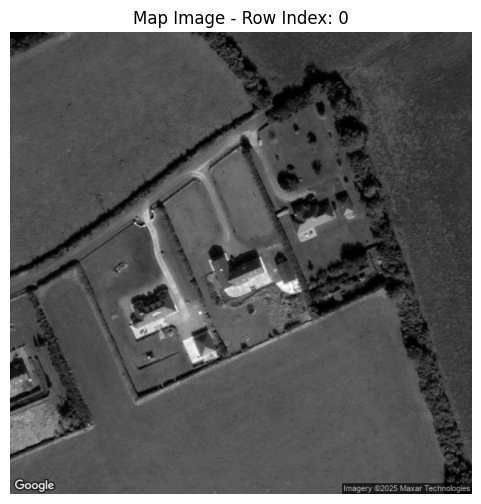

In [36]:
row_index_to_view = 0

# Specify the column containing the pixel arrays
pixel_column = 'map_pixel_array' # Use the actual column name

# --- Code to Display the Image ---

# Check if the DataFrame exists and is not empty
if 'df_with_pixels_test' in locals() and not df_with_pixels_test.empty:
    # Check if the row index is valid
    if row_index_to_view < len(df_with_pixels_test):
        # Get the pixel array from the specified row and column
        try:
            target_array = df_with_pixels_test.loc[row_index_to_view, pixel_column]

            # Check if the extracted data is a valid NumPy array
            if isinstance(target_array, np.ndarray):
                print(f"Displaying image from row index {row_index_to_view}...")

                # Display the array as an image using Matplotlib
                plt.figure(figsize=(6, 6)) # Adjust figure size as needed
                # Use cmap='gray' for grayscale images
                plt.imshow(target_array, cmap='gray', vmin=0, vmax=255)
                plt.title(f"Map Image - Row Index: {row_index_to_view}")
                plt.axis('off') # Hide axes ticks and labels
                plt.show()

            elif target_array is None:
                print(f"Error: No pixel data found for row index {row_index_to_view} (value is None). Fetching might have failed.")
            else:
                print(f"Error: Data in column '{pixel_column}' at row index {row_index_to_view} is not a NumPy array.")
                print(f"Data type found: {type(target_array)}")

        except KeyError:
            print(f"Error: Column '{pixel_column}' not found in the DataFrame.")
        except IndexError:
             print(f"Error: Row index {row_index_to_view} is out of bounds for the DataFrame.")

    else:
        print(f"Error: Row index {row_index_to_view} is out of bounds (DataFrame has {len(df_with_pixels_test)} rows).")
else:
    print("Error: DataFrame 'df_with_pixels_test' not found or is empty.")

In [23]:
# Reload functionality
def load_dataframe_from_pickle(file_path: str) -> Optional[pd.DataFrame]:
    """
    Loads a pandas DataFrame from a specified Pickle (.pkl) file.

    Args:
        file_path (str): The full path to the .pkl file to load.

    Returns:
        Optional[pd.DataFrame]: The loaded pandas DataFrame if successful,
                                otherwise None if an error occurs (e.g., file not found).
    """
    print(f"--- Loading DataFrame from Pickle ---")
    print(f"File path: {file_path}")

    try:
        # Use pandas read_pickle function
        loaded_df = pd.read_pickle(file_path)

        print(f"\nSuccessfully loaded DataFrame.")
        print(f"Shape: {loaded_df.shape}")
        # Optional: Display basic info automatically upon load
        # print("\n--- DataFrame Info ---")
        # loaded_df.info(verbose=False, memory_usage=False) # Concise info

        return loaded_df

    except FileNotFoundError:
        print(f"\nError: Pickle file not found at '{file_path}'.")
        print("Please ensure the path and filename are correct.")
        return None
    except ImportError as e:
        # Might occur if the pickle file contains custom classes not defined
        # in the current environment. Less likely if saved purely with pandas/numpy.
         print(f"\nError: An import error occurred during unpickling: {e}")
         print("This might happen if the pickle file requires specific libraries or custom classes.")
         return None
    except Exception as e:
        # Catch other potential errors during the unpickling process
        print(f"\nAn unexpected error occurred while loading the Pickle file: {e}")
        import traceback
        traceback.print_exc() # Print detailed traceback for debugging
        return None


In [39]:
# --- Example Usage ---

# 1. Specify the path to the pickle file you want to load
# Make sure this path is correct for your system
pickle_file_to_load = 'TEST_pixels_640x640_z19_satellite.pkl' # <-- CHANGE if needed

# 2. Call the function to load the data
my_dataframe = load_dataframe_from_pickle(pickle_file_to_load)

# 3. Check if loading was successful before using the DataFrame
if my_dataframe is not None:
    print("\n--- DataFrame loaded successfully. You can now work with it. ---")

    # Example: Show the head of non-pixel columns
    pixel_col = 'map_pixel_array' # Adjust if your column name is different
    if pixel_col in my_dataframe.columns:
        display_cols = [col for col in my_dataframe.columns if col != pixel_col]
    else:
        display_cols = my_dataframe.columns.tolist() # Show all if pixel col not found

    print("\nHead of non-pixel columns:")
    print(my_dataframe[display_cols].head())

    # Example: Verify an array (optional)
    if pixel_col in my_dataframe.columns and not my_dataframe.empty:
        first_valid_pixel = my_dataframe[my_dataframe[pixel_col].notna()][pixel_col].iloc[0]
        if isinstance(first_valid_pixel, np.ndarray):
             print(f"\nFirst valid pixel array shape: {first_valid_pixel.shape}")

    # You can now perform any other operations on 'my_dataframe'
    # e.g., my_dataframe.describe(), display specific images, etc.

else:
    print("\n--- DataFrame loading failed. ---")

--- Loading DataFrame from Pickle ---
File path: TEST_pixels_640x640_z19_satellite.pkl

Successfully loaded DataFrame.
Shape: (10, 40)

--- DataFrame loaded successfully. You can now work with it. ---

Head of non-pixel columns:
   OBJECTID     Planning Authority  Application Number  \
0       1.0  Carlow County Council                 161   
1       2.0  Carlow County Council                1610   
2       3.0  Carlow County Council               16100   
3       4.0  Carlow County Council               16101   
4       5.0  Carlow County Council               16102   

                             Development Description  \
0  to construct a two storey split level dwelling...   
1  to construct a 256sqm single storey dwelling w...   
2  the erection of a single storey agricultural s...   
3  the change of use of part of existing office p...   
4     to construct an extension to its premises \r\n   

                                 Development Address  Development Postcode  \
0      

Displaying image from row index 0...


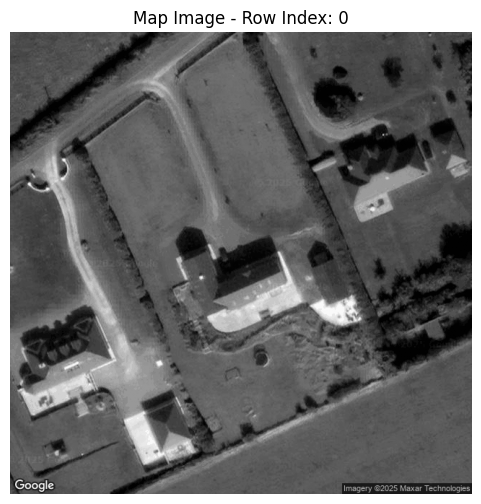

In [41]:
row_index_to_view = 0

# Specify the column containing the pixel arrays
pixel_column = 'map_pixel_array' # Use the actual column name

# --- Code to Display the Image ---

# Check if the DataFrame exists and is not empty
if 'my_dataframe' in locals() and not my_dataframe.empty:
    # Check if the row index is valid
    if row_index_to_view < len(my_dataframe):
        # Get the pixel array from the specified row and column
        try:
            target_array = my_dataframe.loc[row_index_to_view, pixel_column]

            # Check if the extracted data is a valid NumPy array
            if isinstance(target_array, np.ndarray):
                print(f"Displaying image from row index {row_index_to_view}...")

                # Display the array as an image using Matplotlib
                plt.figure(figsize=(6, 6)) # Adjust figure size as needed
                # Use cmap='gray' for grayscale images
                plt.imshow(target_array, cmap='gray', vmin=0, vmax=255)
                plt.title(f"Map Image - Row Index: {row_index_to_view}")
                plt.axis('off') # Hide axes ticks and labels
                plt.show()

            elif target_array is None:
                print(f"Error: No pixel data found for row index {row_index_to_view} (value is None). Fetching might have failed.")
            else:
                print(f"Error: Data in column '{pixel_column}' at row index {row_index_to_view} is not a NumPy array.")
                print(f"Data type found: {type(target_array)}")

        except KeyError:
            print(f"Error: Column '{pixel_column}' not found in the DataFrame.")
        except IndexError:
             print(f"Error: Row index {row_index_to_view} is out of bounds for the DataFrame.")

    else:
        print(f"Error: Row index {row_index_to_view} is out of bounds (DataFrame has {len(df_with_pixels_test)} rows).")
else:
    print("Error: DataFrame 'df_with_pixels_test' not found or is empty.")

In [ ]:
# Change the Data to be only Kerry county council

In [16]:
# Read the CSV file with low_memory=False
df = pd.read_csv('planning_data_with_gps_corrected.csv', low_memory=False)

# Filter for rows containing 'Kerry County Council' in the Planning Authority column
kerry_df = df[df['Planning Authority'].str.contains('Kerry County Council', case=False, na=False)]

# Remove rows where Decision is missing or blank
kerry_df_clean = kerry_df[kerry_df['Decision'].notna() & (kerry_df['Decision'].str.strip() != '')]

# Remove rows where NumResidentialUnits is exactly 1
kerry_df_units = kerry_df_clean[
    (kerry_df_clean['NumResidentialUnits'].notna()) &
    (kerry_df_clean['NumResidentialUnits'] == 1)
    ]


# Robust filtering for AreaofSite
kerry_df_area = kerry_df_units[
    # Check for non-null values
    (kerry_df_units['AreaofSite'].notna()) &
    # Convert to string and check for non-empty
    (kerry_df_units['AreaofSite'].astype(str).str.strip() != '') &
    # Ensure it's not zero
    (kerry_df_units['AreaofSite'] != 0)
    ]

# Drop the specified columns
kerry_df_final = kerry_df_area.drop(columns=[
    'Applicant Forename',
    'Applicant Surname',
    'Applicant Address',
    'Site Id'
])

# Save the filtered and cleaned DataFrame to a new CSV file
kerry_df_final.to_csv('kerry_county_council_planning_data_final.csv', index=False)

# Print summary information
print(f"Original dataset size: {len(df)} rows")
print(f"Kerry County Council dataset size: {len(kerry_df)} rows")
print(f"Kerry County Council dataset (with valid Decisions) size: {len(kerry_df_clean)} rows")
print(f"Kerry County Council dataset (with valid Decisions and Residential Units) size: {len(kerry_df_units)} rows")
print(
    f"Kerry County Council dataset (with valid Decisions, Residential Units, and Site Area) size: {len(kerry_df_area)} rows")
print(f"Final dataset size after dropping applicant and Site Id columns: {len(kerry_df_final)} rows")


Original dataset size: 483570 rows
Kerry County Council dataset size: 12490 rows
Kerry County Council dataset (with valid Decisions) size: 10579 rows
Kerry County Council dataset (with valid Decisions and Residential Units) size: 7015 rows
Kerry County Council dataset (with valid Decisions, Residential Units, and Site Area) size: 6845 rows
Final dataset size after dropping applicant and Site Id columns: 6845 rows


In [32]:
# 1. Path to corrected data file
input_data_file = 'kerry_county_council_planning_data_final.csv'

# 2. Path to secrets file with api key
secrets_file = 'secrets.yml'

# 3. Define desired API request size and zoom (no separate target size needed)
# Use the largest allowed by the API for max detail, e.g., 640x640
api_image_size = (640, 640)
zoom_level = 19 # High zoom level
map_type_requested = 'satellite'

output_pickle_file = f'planning_data_pixels_{api_image_size[0]}x{api_image_size[1]}_z{zoom_level}_sat.pkl'

api_delay = 0.2

In [33]:
# --- Running the Extraction on the Full Dataset ---

print(f"--- Starting Pixel Extraction for FULL dataset ---")
print(f"Input CSV: {input_data_file}")
print(f"Output Pickle: {output_pickle_file}")
print(f"API Settings: Size={api_image_size}, Zoom={zoom_level}, Type={map_type_requested}")
print(f"\n!!! WARNING !!!")
print(f"This will process the entire dataset and may take a significant amount of time.")
print(f"It will also consume API quota/credits for each row with valid coordinates.")
print(f"Ensure your API key is correctly configured and monitor your usage.")
print(f"Processing starting now...")
print("-" * 30)


# Call the function, passing the FILENAME STRING for the full dataset.
# The function is designed to handle loading the CSV specified by the string.
df_full_with_pixels = add_map_pixel_arrays_direct(
    data=input_data_file,
    input_file_type='csv',
    lat_col='latitude',
    lon_col='longitude',
    secrets_path=secrets_file,
    requested_api_size=api_image_size,
    zoom=zoom_level,
    maptype=map_type_requested,
    output_path=output_pickle_file,
    delay_between_requests=api_delay
)

# --- Check the Result (if successful) ---
print("-" * 30)
if df_full_with_pixels is not None:
    print("\n--- Full Run Result Check ---")
    print(f"Processing completed. Final DataFrame shape: {df_full_with_pixels.shape}")

    # Verify the pixel column exists (should be the default name)
    expected_col_name = DEFAULT_PIXEL_COL_NAME # 'map_pixel_array'

    if expected_col_name in df_full_with_pixels.columns:
        # Calculate how many rows successfully got pixel data
        valid_pixel_count = df_full_with_pixels[expected_col_name].notna().sum()
        total_rows = len(df_full_with_pixels)
        success_rate = (valid_pixel_count / total_rows * 100) if total_rows > 0 else 0
        print(f"Successfully added pixel arrays to {valid_pixel_count} out of {total_rows} rows ({success_rate:.2f}% success rate).")

        # Display info (useful for checking memory usage)
        print("\nDataFrame Info:")
        df_full_with_pixels.info(memory_usage='deep') # 'deep' gives a better memory estimate

    else:
        print(f"\nERROR: Expected pixel column '{expected_col_name}' not found in the final DataFrame.")
        print(f"Columns found: {df_full_with_pixels.columns.tolist()}")

    print(f"\nFull results saved to (or attempted to save to): {output_pickle_file}")

else:
    print("\n--- Full Run Failed (Function returned None) ---")
    print("The process was interrupted or encountered a critical error (e.g., file loading, API key).")
    print("Check the error messages printed above during the run.")

print("\n--- Full Dataset Processing Attempt Finished ---")

--- Starting Pixel Extraction for FULL dataset ---
Input CSV: kerry_county_council_planning_data_final.csv
Output Pickle: planning_data_pixels_640x640_z19_sat.pkl
API Settings: Size=(640, 640), Zoom=19, Type=satellite

!!! WARNING !!!
This will process the entire dataset and may take a significant amount of time.
It will also consume API quota/credits for each row with valid coordinates.
Ensure your API key is correctly configured and monitor your usage.
Processing starting now...
------------------------------
--- Starting Map Image Pixel Extraction (Direct Size) ---
Will store pixel arrays in column: 'map_pixel_array'
API Key loaded successfully.
Loading data from: kerry_county_council_planning_data_final.csv
Loaded 6845 records.
Fetching maps (640x640 pixels, zoom 19, type 'satellite')...


Processing Rows:   0%|          | 0/6845 [00:00<?, ?it/s]


--- Processing Summary ---
Successfully processed map arrays for 6845 rows.
Skipped 0 rows due to missing/invalid coordinates.

Saving updated DataFrame to: planning_data_pixels_640x640_z19_sat.pkl
Successfully saved to planning_data_pixels_640x640_z19_sat.pkl.
--- Map Image Pixel Extraction (Direct Size) Finished ---
------------------------------

--- Full Run Result Check ---
Processing completed. Final DataFrame shape: (6845, 36)
Successfully added pixel arrays to 6845 out of 6845 rows (100.00% success rate).

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6845 entries, 0 to 6844
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   OBJECTID                  6845 non-null   float64
 1   Planning Authority        6845 non-null   object 
 2   Application Number        6845 non-null   int64  
 3   Development Description   6845 non-null   object 
 4   Development Address  

In [ ]:
# Try to load from file

In [34]:
# 1. Define the EXACT path to the FULL dataset pickle file you saved
#    This MUST match the 'output_pickle_file_full' used in the previous step.
#    Adjust the filename components (size, zoom, maptype) if they were different.
full_pickle_path = 'planning_data_pixels_640x640_z19_sat.pkl'

# 2. Call the loading function
print(f"\n--- Attempting to load the full dataset from: {full_pickle_path} ---")
df_full_loaded = load_dataframe_from_pickle(full_pickle_path)

# 3. Check if loading was successful and verify the loaded data
if df_full_loaded is not None:
    print("\n--- Full Dataset Loaded Successfully ---")

    # Basic checks
    print(f"Loaded DataFrame shape: {df_full_loaded.shape}")

    # Detailed info including memory usage
    print("\nDataFrame Info:")
    try:
        df_full_loaded.info(memory_usage='deep')
    except Exception as info_err:
        print(f"Could not get detailed info: {info_err}")
        df_full_loaded.info() # Fallback to basic info

    # Check head of non-pixel columns
    pixel_col = 'map_pixel_array' # Make sure this is the correct column name
    if pixel_col in df_full_loaded.columns:
        display_cols = [col for col in df_full_loaded.columns if col != pixel_col]
        print(f"\nHead of non-pixel columns (column '{pixel_col}' excluded):")
        print(df_full_loaded[display_cols].head())

        # Optionally verify an array from the loaded full data
        if not df_full_loaded.empty:
            try:
                # Find first row with a non-null value in the pixel column
                first_valid_row = df_full_loaded[df_full_loaded[pixel_col].notna()].iloc[0]
                first_valid_pixel = first_valid_row[pixel_col]

                if isinstance(first_valid_pixel, np.ndarray):
                    print(f"\nVerified: Pixel data in row index {first_valid_row.name} is a NumPy array with shape {first_valid_pixel.shape}")
                    # You could even display this image again using matplotlib if needed
                else:
                    print(f"\nWarning: Data in '{pixel_col}' (row index {first_valid_row.name}) is type {type(first_valid_pixel)}, not NumPy array.")
            except IndexError:
                 print(f"\nInfo: No non-null values found in the '{pixel_col}' column to verify.")
            except Exception as check_err:
                 print(f"\nError during verification check: {check_err}")

    else:
         print(f"\nWarning: Pixel column '{pixel_col}' not found in loaded DataFrame.")
         print("\nHead of all columns:")
         print(df_full_loaded.head()) # Show head of all columns if pixel one isn't there

    print("\n--- You can now work with the 'df_full_loaded' DataFrame ---")

else:
    print("\n--- Failed to load the full dataset pickle file. ---")
    print("Please check the file path and any error messages printed above.")


--- Attempting to load the full dataset from: planning_data_pixels_640x640_z19_sat.pkl ---
--- Loading DataFrame from Pickle ---
File path: planning_data_pixels_640x640_z19_sat.pkl

Successfully loaded DataFrame.
Shape: (6845, 36)

--- Full Dataset Loaded Successfully ---
Loaded DataFrame shape: (6845, 36)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6845 entries, 0 to 6844
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   OBJECTID                  6845 non-null   float64
 1   Planning Authority        6845 non-null   object 
 2   Application Number        6845 non-null   int64  
 3   Development Description   6845 non-null   object 
 4   Development Address       6845 non-null   object 
 5   Development Postcode      0 non-null      float64
 6   Application Status        6845 non-null   object 
 7   Application Type          6845 non-null   object 
 8   Decision    

In [35]:
# confirming the dataframe again.
df_full_loaded

OBJECTID    Planning Authority  Application Number  \
0      68058.0  Kerry County Council               16100   
1      68060.0  Kerry County Council              161001   
2      68062.0  Kerry County Council              161003   
3      68063.0  Kerry County Council              161004   
4      68064.0  Kerry County Council              161005   
...        ...                   ...                 ...   
6840   80341.0  Kerry County Council             2461008   
6841   80345.0  Kerry County Council             2461015   
6842   80346.0  Kerry County Council             2461017   
6843   80348.0  Kerry County Council             2560002   
6844   80357.0  Kerry County Council               24419   

                                Development Description  \
0     RETAIN EXISTING DWELLING AND GARAGE ALL WITHIN...   
1     CHANGE THE USE OF GROUND FLOOR OFFICES TO LIVI...   
2     (A) DEMOLISH EXISTING GARAGE, (B) CONSTRUCT AN...   
3     CONSTRUCT TWO BUNGALOWS INCORPORATING ATTIC ST...   
4     FOR THE INSTALLATION OF A COMMUNITY MECHANICAL...   
...                                                 ...   
6840  Demolition of existing outhouse, construction ...   
6841  change the use of an existing dwelling house f...   
6842  (a) construction of detached two storey dwelli...   
6843  The development will consist of:\r\nA)\t Demol...   
6844  (I) RETAIN THE RELOCATION OF THE EXISITNG "CLI...   

                                    Development Address  Development Postcode  \
0                   KNOCKANUSH EAST , TRALEE , CO KERRY                   NaN   
1                    2 HILLTOP , BRIDGE ROAD , LISTOWEL                   NaN   
2                        KILMEANY , KILMORNA , LISTOWEL                   NaN   
3               DOOLAIG SOUTH , CASTLEISLAND , CO KERRY                   NaN   
4                BALLYNAMAUNAGH , KILCUMMIN , KILLARNEY                   NaN   
...                                                 ...                   ...   
6840                Termons , Waterville , County Kerry                   NaN   
6841  No. 2 Bothar Sheen , Glanerought Dromneavane ,...                   NaN   
6842             20 Golf View , Ballygowloge , Listowel                   NaN   
6843                  Gortaglanna , Kilmorna , Listowel                   NaN   
6844  A.C. 0.0141 HA SITE IN THE CAR PARK OF TESCO ,...                   NaN   

         Application Status Application Type     Decision Land Use Code  ...  \
0     APPLICATION FINALISED        RETENTION  CONDITIONAL            GD  ...   
1     APPLICATION FINALISED       PERMISSION  CONDITIONAL            LP  ...   
2     APPLICATION FINALISED       PERMISSION  CONDITIONAL            GD  ...   
3     APPLICATION FINALISED       PERMISSION  CONDITIONAL            GD  ...   
4     APPLICATION FINALISED       PERMISSION      REFUSED            GD  ...   
...                     ...              ...          ...           ...  ...   
6840          DECISION MADE       PERMISSION  CONDITIONAL                ...   
6841          DECISION MADE       PERMISSION  CONDITIONAL                ...   
6842          DECISION MADE       PERMISSION  CONDITIONAL                ...   
6843          DECISION MADE       PERMISSION  CONDITIONAL                ...   
6844  APPLICATION FINALISED        RETENTION  CONDITIONAL            LP  ...   

                  FIRecDate  \
0      4/6/2016 12:00:00 AM   
1                       NaN   
2     3/16/2017 12:00:00 AM   
3                       NaN   
4                       NaN   
...                     ...   
6840                    NaN   
6841                    NaN   
6842                    NaN   
6843                    NaN   
6844                    NaN   

                               Link Application Details One-Off KPI  \
0     http://www.eplanning.ie/KerryCC/AppFileRefDeta...          No   
1     http://www.eplanning.ie/KerryCC/AppFileRefDeta...          No   
2     http://www.eplanning.ie/KerryCC/AppFileRefDeta... 

In [36]:
def display_map_image(
    df: pd.DataFrame,
    row_index: Any, # Use 'Any' as index can be integer, string, etc.
    pixel_col: str = 'map_pixel_array',
    figsize: Tuple[int, int] = (6, 6),
    title: Optional[str] = None,
    show_axes: bool = False
    ) -> None:
    """
    Displays a map image stored as a NumPy array in a DataFrame cell.

    Args:
        df (pd.DataFrame): The DataFrame containing the pixel data.
        row_index (Any): The index label (e.g., integer position, string label)
                         of the row to display.
        pixel_col (str): The name of the column containing the NumPy pixel arrays.
                         Defaults to 'map_pixel_array'.
        figsize (Tuple[int, int]): The size of the figure for display (width, height).
                                   Defaults to (6, 6).
        title (Optional[str]): Custom title for the plot. If None, a default
                               title including the row index will be used.
                               Defaults to None.
        show_axes (bool): Whether to display the plot axes. Defaults to False.

    Returns:
        None: This function displays a plot but does not return any value.
    """
    print(f"--- Attempting to display image ---")
    print(f"DataFrame Shape: {df.shape}")
    print(f"Target Row Index: {row_index}")
    print(f"Pixel Column: '{pixel_col}'")

    # Basic check on the DataFrame
    if not isinstance(df, pd.DataFrame) or df.empty:
        print("Error: Invalid or empty DataFrame provided.")
        return

    try:
        # --- Access the data using .loc with the provided row index ---
        target_array = df.loc[row_index, pixel_col]

        # --- Check the retrieved data ---
        if isinstance(target_array, np.ndarray):
            print(f"\nDisplaying image from row index {row_index}...")

            # Set default title if none provided
            if title is None:
                plot_title = f"Map Image - Row Index: {row_index}"
            else:
                plot_title = title

            # --- Display using Matplotlib ---
            plt.figure(figsize=figsize)
            # Use cmap='gray' and set intensity range for grayscale
            plt.imshow(target_array, cmap='gray', vmin=0, vmax=255)
            plt.title(plot_title)
            if not show_axes:
                plt.axis('off') # Hide axes by default
            plt.show()

        elif target_array is None:
            print(f"\nError: No pixel data found for row index {row_index} in column '{pixel_col}' (value is None).")
            print("Data might be missing or fetching/processing failed for this row.")
        else:
            print(f"\nError: Data in column '{pixel_col}' at row index {row_index} is not a NumPy array.")
            print(f"Data type found: {type(target_array)}")

    except KeyError:
        # This handles two cases: row_index doesn't exist OR pixel_col doesn't exist
        if row_index not in df.index:
            print(f"\nError: Row index '{row_index}' not found in the DataFrame index.")
        elif pixel_col not in df.columns:
            print(f"\nError: Pixel column '{pixel_col}' not found in the DataFrame columns.")
        else:
            # Should not happen if the above catches work, but as a fallback
            print(f"\nError: Could not access data at index '{row_index}', column '{pixel_col}'.")
    except Exception as e:
        print(f"\nAn unexpected error occurred during display: {e}")
        import traceback
        traceback.print_exc()

--- Attempting to display image ---
DataFrame Shape: (6845, 36)
Target Row Index: 0
Pixel Column: 'map_pixel_array'

Displaying image from row index 0...


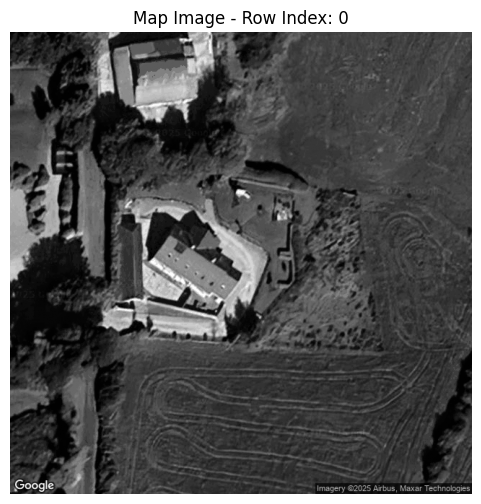

--- Attempting to display image ---
DataFrame Shape: (6845, 36)
Target Row Index: 5
Pixel Column: 'map_pixel_array'

Displaying image from row index 5...


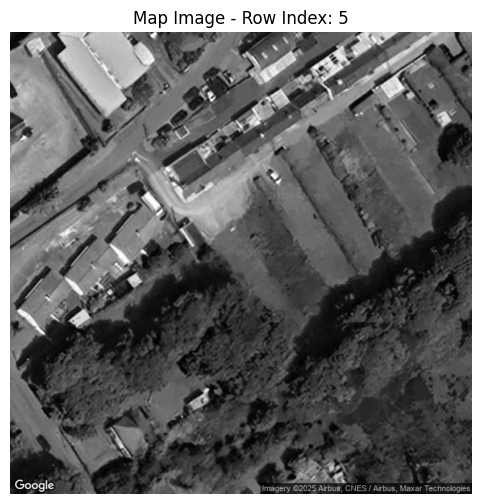

In [37]:
# --- Example Usage ---
index_to_show = 0 # Example: Display the first row (index 0)
display_map_image(df_full_loaded, row_index=index_to_show)
# --- Example: Display another row with a custom title ---
index_to_show_2 = 5
display_map_image(df_full_loaded, row_index=index_to_show_2)